In [8]:
#packages
import numpy as np
import matplotlib.pyplot as plt
import math
import random

    Abstract

Pyramidal neurons in the CA3 region of the hippocampus has an important role in 
encoding visuo-spatial information, but the exact biophysical mechanisms how these neurons 
transform their synaptic input to action potential output yet remained unclear. Studies in other 
brain areas have shown that dendritic spikes may contribute to input amplification and may 
enhance the computational power of a single neuron. Dendritic spikes can be global events, 
propagating to majority of the dendritic tree and trigger somatic action potentials, but can also 
occur in an isolated manner, when parts of dendritic trees can be independently active from other 
dendritic branches or the soma. The existence of such isolated dendritic events would strongly 
support the theoretical prediction that dendritic nonlinearities can enhance the computational 
power of single neurons. However, no such isolated dendritic spikes have been observed in CA3 
pyramidal neurons.

Here I analysed dendritic and somatic activity of CA3 pyramidal neurons recorded in 
mice exploring a virtual reality environment to detect the coupling between the somatic and 
dendritic activity. Mice were injected with a low concentration of adenovirus carrying the gene 
of a fluorescent indicator, GCaMP8 and the activity of the somatic and dendritic region of 
individual neurons were monitored using a two-photon microscope. Fluorescent transients were 
detected on both dendritic and somatic regions, and we found that most of these events were 
synchronised across the entire dendritic tree. However, a minority of the dendritic events 
occurred without detectable somatic transients, raising the possibility, that these events might 
reflect independent dendritic spikes (true transients). Alternatively, transients localised to small 
region can be caused by fluorescent activity originating from a structure (soma, dendrite or axon) 
of a different neuron (false transients). Here I implemented an algorithm that is able to separate 
false transients from true transients based on their spatial pattern of activity. I tested the 
algorithm on synthetic data that matched several statistical properties of the real data (signal-to-noise ratio, temporal decay). 

When I analysed signals recorded from a single neuron in vivo, I found that most of the 
transients were true transients, and I successfully detected isolated dendritic events, however on 
the observed movie data the most detected events were showed coupled somato-dendritic 
activity. We are planning to use the algorithm on a broader set of recordings to characterise the 
prevalence and the spatio-temporal properties of independent dendritic events in CA3 pyramidal 
neurons.

References:

Gauthier, J. L., Charles, A. S., Pillow, J. W., Tank, D. W., Nieh, E. H., & Koay, S. A. (2022) Detecting and correcting false transients in calcium imaging. Nature methods. Retrieved January 30, 2023, from https://pubmed.ncbi.nlm.nih.gov/35347320

Neugornet, A., O’Donovan, B., & Ortinski, P. I. (2021). Comparative effects of event 
detection methods on the analysis and interpretation of Ca2+
imaging data. Frontiers in 
Neuroscience, 15. https://doi.org/10.3389/fnins.2021.620869

Note: The current research – in which I also took part with my thesis project – was carried out by the Biological Computations and the Neuronal Signalling research groups at the Institute of Experimental Medicine/Kísérleti 
Orvostudományi Kutató Intézet (IOEM/KOKI).

In this notebook I present how I generated the synthetic dataset and I present the temporal event detection algorithm.

Synthetic data generation is a commonly used method in computational neuroscience. In general, 
the advantage of generating synthetic data is that it enables researchers to develop a robust 
algorithmic solution for solving a specific problem. Generating synthetic data is mostly a 
bottom-up process, whereas data analysis is a top-down process. Given the nature of synthetic 
data, even if the data analysis algorithm is not sufficient, there will always be opportunities to 
manipulate and deconstruct the data to better understand the potential limitations of our data 
analysis tools and then improve them.

On the original dataset - which I wish to replicate - we can see the Ca2+
fluorescent activity of 
mice hippocampal CA3 pyramidal neurons. Therefore, based on the idea of synthetic data 
generation introduced, the aim of this subsection is to show how I have modelled the Ca2+ 
fluorescence activity of CA3PNs. In the synthetic dataset, I generated the backpropagation signal 
of the soma (soma A), the local signal of the dendrite (dendrite A) and the contaminating signal 
of another soma (soma B).

## Spike trains:

The first step in the generation of synthetic Ca2+ signals is the generation of neuronal spikes, 
which indicate temporal activity. I started the data generation by generating neural spikes (si). 
For neural spike generation I implemented a randomized Poission process. Poission process is 
simply a sequence of events within a specific time frequency. I observed relatively low 
frequency activity in real neural recordings, therefore I defined fr (s) = 0.2 for somatic spike and 
fr (d) = fr (s) / 0.5 for dendritic spike frequency. The spikes were then randomized so that they 
did not occur at the same time interval, simulating real activity. For the total length of the spike 
trains, I took 900 secundum (15 minutes) time interval with a sampling frequency of 30 Hz, 
which is equal to a 27000 time bins.

In [9]:
np.random.seed(45)

fr = 0.05 # frequency
fr_2 = fr/1.2 # frequency
dt = 1/30.0; # s
Tmax = 900 # s
t = np.arange(0, Tmax, dt)
nBins = np.round(Tmax / dt).astype(int) # 5 min spike train
nTrials = 1; # Number of trials
myPoissonSpikeTrain_1 = np.random.rand(1,nBins) < fr*dt; # Poisson spike train built by logical values
spikes_a = myPoissonSpikeTrain_1.flatten()*1 # convert to np.array

myPoissonSpikeTrain_2 = np.random.rand(1,nBins) < fr_2*dt; # Poission spike train built by logical values
spikes_a_dend = myPoissonSpikeTrain_2.flatten()*1 # convert to np.array

myPoissonSpikeTrain_3 = np.random.rand(1,nBins) < fr*dt; # Poission spike train built by logical values
spikes_b = myPoissonSpikeTrain_3.flatten()*1 # convert to np.array


#time
time_scale = np.linspace(0,Tmax,10) # 15 min timebin
tcks = list(np.linspace(0,len(spikes_a), 10))
time_scale = time_scale.astype(int)

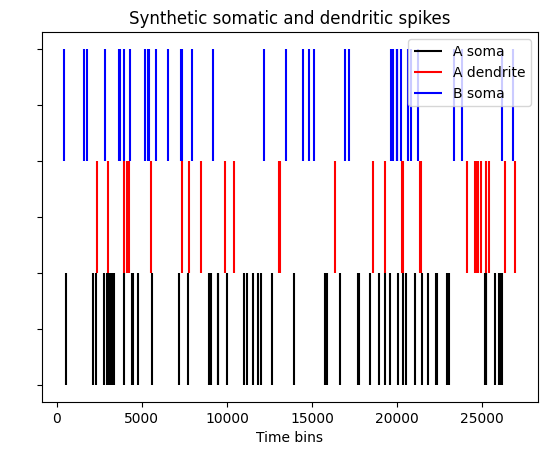

In [10]:
asspikes = plt.vlines(np.flatnonzero(spikes_a), 0, 1, 'k')
adspikes = plt.vlines(np.flatnonzero(spikes_a_dend), 1, 2, 'r')
bsspikes = plt.vlines(np.flatnonzero(spikes_b), 2, 3, 'b')
plt.title('Synthetic somatic and dendritic spikes')
plt.xlabel('Time bins')
#plt.xticks(ticks = tcks, labels = time_scale)
plt.yticks(color='w')
plt.legend([asspikes,adspikes,bsspikes], ['A soma', 'A dendrite', 'B soma'])
plt.show()

For simulating the time consuming process wherein fluorescent fluid carried CA2+ molecules flows out to the extracellular space, I have to add realistic decays to the neural spikes. To implement this, I define the following convolutional kernel: exp(time/tau) - tau = 2, time = 300. For convolution mode I used valid mode, since keeping the initial dimenions are not important. After tthe convolution we use the results as synthetic fluorescent signals.

Also in the next cell I add baseline fluctuation and specifiy the power of the baseline to have roughly the same values like the original data possess. 

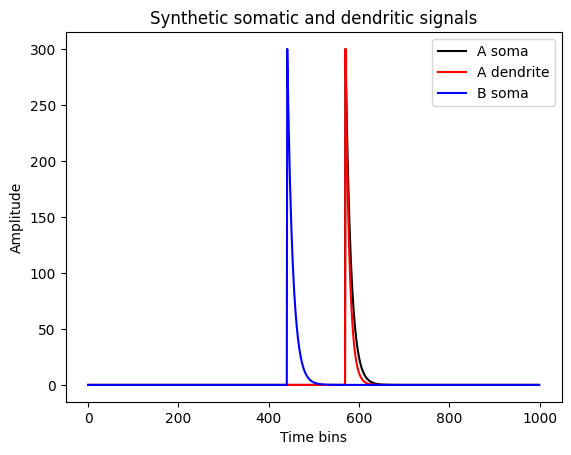

In [12]:
#causal_conv_ker ?
np.random.seed(85)
Lmax = 900
tt = np.arange(Lmax) / 30.0
tau_soma = 0.4
convker_soma = np.exp(-tt/tau_soma)
tau_dend = 0.3
convker_dend = np.exp(-tt/tau_dend)

# convolution
dF_a_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a)), convker_soma, mode='valid') * 300
dF_a_dend = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_a + spikes_a_dend)), convker_dend, mode='valid') * 300
dF_b_soma = np.convolve(np.hstack((np.zeros(Lmax-1), spikes_b)), convker_soma, mode='valid') * 300

Text(0.5, 1.0, 'Synthetic somatic signal - B soma')

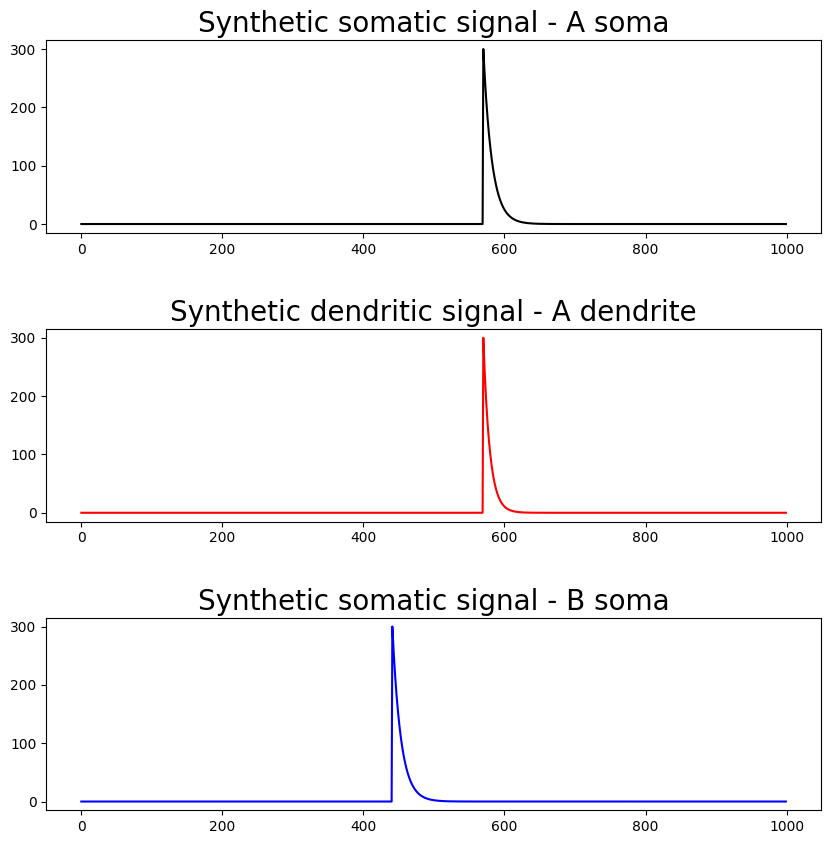

In [33]:
fig = plt.figure(figsize=(10, 10))

rows = 3
columns = 1

plt.subplots_adjust(hspace=0.5)

#1
fig.add_subplot(rows, columns, 1)
plt.plot(dF_a_soma[0:1000], 'k')
plt.title('Synthetic somatic signal - A soma', fontsize = 20)

#2
fig.add_subplot(rows, columns, 2)
plt.plot(dF_a_dend[0:1000], '-r')
plt.title('Synthetic dendritic signal - A dendrite', fontsize = 20)

#3
fig.add_subplot(rows, columns, 3)
plt.plot(dF_b_soma[0:1000], '-b')
plt.title('Synthetic somatic signal - B soma', fontsize = 20)

Next, I generate rectangles (40 x 40 for somas, 20 x 50 for the dendrite) inside a 100 x 100 shape pictures.

## Generate images:

In [15]:
x_1 = np.zeros(100)
x_1[11:51] = 1
y_1 = np.zeros(100)
y_1[10:50] = 1

x_2 = np.zeros(100)
x_2[51:81] = 1
y_2 = np.zeros(100)
y_2[20:35] = 1

x_3 = np.zeros(100)
x_3[51:91] = 1
y_3 = np.zeros(100)
y_3[21:61] = 1 # was 30:69

In [16]:
a_soma = np.outer(x_1, y_1)
dendrites = np.outer(x_2,y_2)
b_soma = np.outer(x_3,y_3)

masks = a_soma + 2*dendrites + 4*b_soma

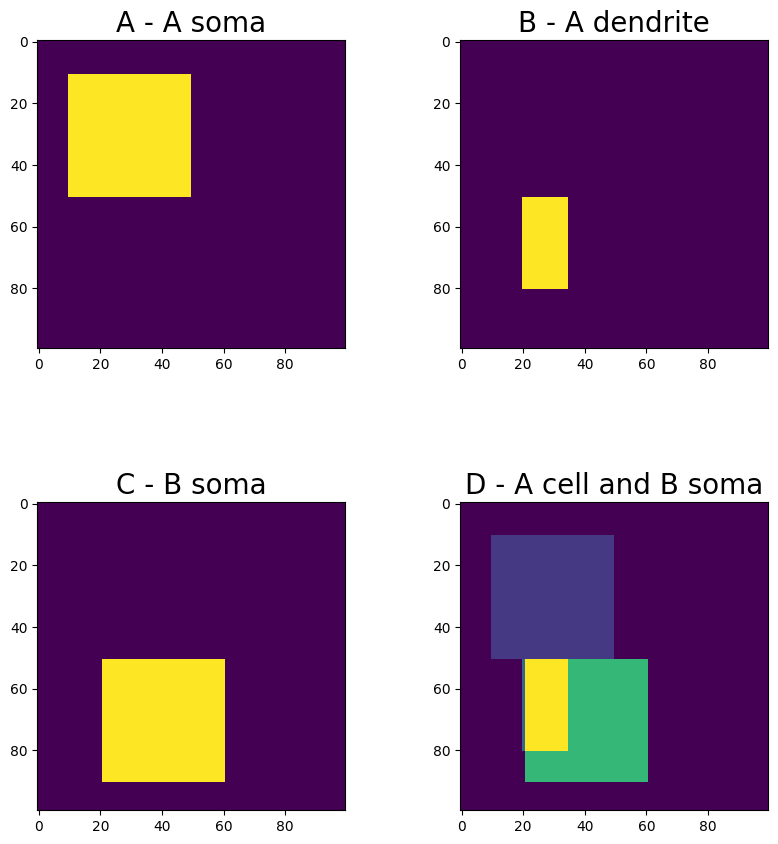

In [36]:
fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2

plt.subplots_adjust(hspace=0.5)

#1
fig.add_subplot(rows, columns, 1)
plt.imshow(a_soma)
plt.title('A - A soma', fontsize = 20)

#2
fig.add_subplot(rows, columns, 2)
plt.imshow(dendrites)
plt.title('B - A dendrite', fontsize = 20)

#3
fig.add_subplot(rows, columns, 3)
plt.imshow(b_soma)
plt.title('C - B soma', fontsize = 20)

#4
fig.add_subplot(rows, columns, 4)
plt.imshow(masks)
plt.title('D - A cell and B soma', fontsize = 20)

masks_save = np.save('masks', masks)
asoma_save = np.save('asomabase', a_soma)
adendrite_save = np.save('adendritebase', dendrites)
bsoma_save = np.save('bsomabase', b_soma)

For having a realistic neuronal sequence we have to take the outer product of the signals and the generated pictures, which results in three 27000 x 10000 matrices.

## Synthetic frames:

In [18]:
a_soma_flat = a_soma.flatten()*1
dendrites_flat = dendrites.flatten()*1
b_soma_flat = b_soma.flatten()*1

a_soma_frames = np.outer(a_soma_flat, dF_a_soma)
dendrites_frames = np.outer(dendrites_flat, dF_a_dend)
b_soma_frames = np.outer(b_soma_flat, dF_b_soma)

In [19]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=(15, 6))

#1
axs[0].imshow(a_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[0].set_xlim(0, len_dF)

#2
axs[1].imshow(dendrites_frames[:,:], cmap='Greys', aspect = 'auto')
axs[1].set_xlim(0, len_dF)

#3
axs[2].imshow(b_soma_frames[:,:], cmap='Greys', aspect = 'auto')
axs[2].set_xlim(0, len_dF)

I add realistic noise to the signals by using the paramteres (location/mean = 10, sigma/standard deviation = 20) extracted by the noise analysis and recreate it by np.random.normal fucntion that calls a normal distribution of random numbers given the latter paramteres. After this, I concetanate the matrices into one 1500x40 size matrix.

In [20]:
noise = np.random.normal(loc=400, scale=60, size = (10000, nBins))

In order to have a full 3D data, the reshape of 1500x40 size matrix to 1500x20x20 tensor is required.

In [ ]:
len_dF = len(dF_a_soma)

In [21]:
dF0 = a_soma_frames + dendrites_frames + b_soma_frames + noise # add the matrices + add noise
dF = dF0.reshape((100,100, len_dF))

In [22]:
f, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 3))
axs.imshow((dF0[:,:]+1), cmap='Greys_r', aspect = 'auto')
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)

In the following section I introduce the data analysis method that was built and optimized on the previous dataset. The method has three major parts. In the first part I define the mask coordinate of the region of interest, which for simplicity, are the coordinates of the synthetic somas and dendrites. In the second part, I use the masks to extract the fluorescent signals then filter the signals with convolving them by a moving Gauss-window - theoretically the more we increase the value of sigma the more high frequency signal ranges can be filtered out, which results in smoothened signal with less high noise fluctuations (noise tipically exist in high frequency ranges). Finally, in the last part I developed a simple event detection function that detects the events above a specific threshold (theta_upper) and refracterize remaining part of the signal array until it reaches a secondary threshold (theta_lower), which is set below the signal orginal signal detector. 

## Data analysis - extracting synthetic dF and dF/F Ca2+ signals from the above generated dataset:

The first step of the data analysis is the signal extraction. To extract the signals, first, I took the ROI areas 
and calculated the average pixel values of each ROI in every timepoint (Neugornet, 
2021). This method returns the average Ca2+ fluorescence activity of the somatic and dendritic 
region over the observed time interval (Neugornet, 2021). We call these signal as delta
fluorescent signal (dF) (Neugornet, 2021).

Since each dF signal have different baseline, in the last step we need to align every dF signal to 
the same baseline (Neugornet, 2021). To achieve this, I subtracted the F0 (median of F) from it
and divided it by F0 (Neugornet, 2021). We mark the result of this operation as dF/F.

In [23]:
#orginial mask coordinates
a_soma_mask = np.array(np.where(a_soma == 1))

a_dend_mask = np.array(np.where(dendrites == 1))

b_soma_mask = np.array(np.where(b_soma == 1))

synthetic_roi_masks = [a_soma_mask, a_dend_mask, b_soma_mask]

In [25]:
i_mask = 0
mask = synthetic_roi_masks[i_mask]
L_mask = mask.shape[0]
signal = np.zeros(dF.shape[2])
for i_pixel in np.arange(L_mask):
    pix = mask[:,i_pixel]
    signal = signal + dF[pix[0], pix[1],:]
signal1 = signal / L_mask

Text(0, 0.5, 'Signal amplitude')

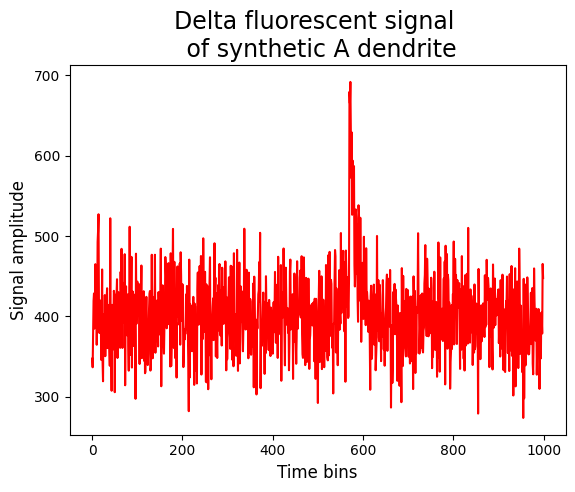

In [26]:
plt.plot(signal1[0:1000], 'r')
plt.title('Delta fluorescent signal \n of synthetic A dendrite', fontsize = 17)
plt.xlabel('Time bins', fontsize = 12)
plt.ylabel('Signal amplitude', fontsize = 12)

In [27]:
def ROI_std(mask_number):
    mask_array  = synthetic_roi_masks.copy()
    j_mask = mask_number
    mask_ = mask_array[j_mask]
    L_mask_ = mask_.shape[0]
    signal_ = np.zeros(dF.shape[2])
    for j_pixel in np.arange(L_mask_):
        pix_ = mask_[:,j_pixel]
        signal_ = signal_ + dF[pix_[0], pix_[1],:]
    signal_ = signal_ / L_mask_
    DF = signal_.copy()
    DFpF = (signal_ - np.median(signal_)) / np.median(signal_)
    ampl = max(DFpF)
    return DF,DFpF, ampl, np.std(DFpF)

In [28]:
df_sigs = []
sigs = []
SDs = np.zeros(3)
for i in range(3):
    df, sig, ampl_sig, SD_sig = ROI_std(i)
    SDs[i] = SD_sig # SD_sig
    df_sigs.append(df)
    sigs.append(sig)

In [29]:
print(SDs)

[0.13621163 0.14499021 0.15703196]


Text(0.5, 1.0, 'Synthetic dF/F signals - B soma')

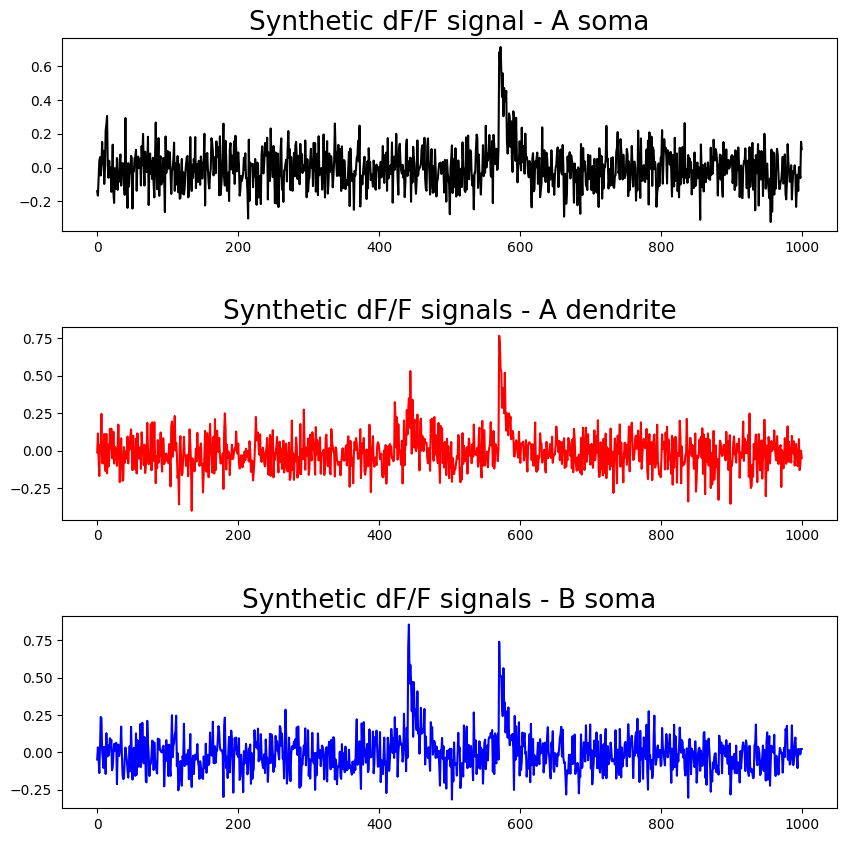

In [37]:
# Same previous plot with different layout
fig = plt.figure(figsize=(10, 10))

rows = 3
columns = 1

plt.subplots_adjust(hspace=0.5)

#1
fig.add_subplot(rows, columns, 1)
plt.plot(sigs[0][0:1000], 'k')
plt.title('Synthetic dF/F signal - A soma', fontsize = 19)

#2
fig.add_subplot(rows, columns, 2)
plt.plot(sigs[1][0:1000], '-r')
plt.title('Synthetic dF/F signals - A dendrite', fontsize = 19)

#3
fig.add_subplot(rows, columns, 3)
plt.plot(sigs[2][0:1000], '-b')
plt.title('Synthetic dF/F signals - B soma', fontsize = 19)

## Data analysis - measuring the standard deviation of the noise:

In the next cell I extract the standard deviation and the mean of random pixels (100) then take their mean. It is important that pixel coordinates need to fall out of the neural compartment masks, so we can assume that the extracted signal represents the noise.

In [56]:
M = 100
noise_m_and_std = np.zeros((2, M))
noise_ij = np.zeros((2, M))
for m in np.arange(M):
    j = np.random.randint(52,98) 
    i = np.random.randint(5,50)
    noise_m_and_std[0,m] = np.mean(dF[i,j,:])
    noise_m_and_std[1,m] = np.std(dF[i,j,:])
    noise_ij[:,m] = [i,j]
print(np.mean(noise_m_and_std, axis=1))

[399.94285808  59.96504598]


Density of noise signals:

Text(0, 0.5, 'Estimated number of standard deviation values')

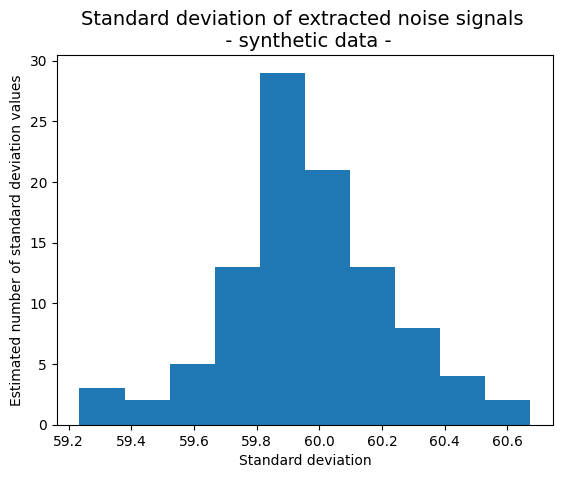

In [57]:
plt.hist(noise_m_and_std[1])
plt.title('Standard deviation of extracted noise signals \n - synthetic data -', fontsize = 14)
plt.xlabel('Standard deviation')
plt.ylabel('Estimated number of standard deviation values')

Both values are close to the values extraced from real data.

In [58]:
# function for plotting the noise pixels on the total view of synthetic data
def noise_pixel_plot(pic, add_points = None):
    fig0, ax2 = plt.subplots()
    ax2.matshow(pic)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    if (add_points is not None):
            ax2.scatter(add_points[1,:], add_points[0,:], color="white", marker="+")

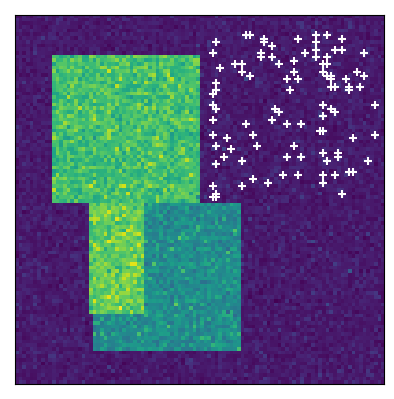

In [60]:
maxIm = np.max(dF, axis=2)
noise_pixel_plot(maxIm, noise_ij)

Next I measure the SE of each synthetic ROI and the SD of an arbitrary period of each generated fluorescent signal.

In [61]:
def ExpSD(sigE, mask):
    signal = np.array(sigE)
    N = len(mask[1])
    expSD = 56 / np.sqrt(N)
    print(np.std(sigE[0:200]))
    print(expSD)

In [62]:
ExpSD(df_sigs[0],a_soma_mask)

44.832775454320696
1.4


In [63]:
ExpSD(df_sigs[1],a_dend_mask)

44.109749746084134
2.6398653164297774


In [64]:
ExpSD(df_sigs[2],b_soma_mask)

44.0409431779004
1.4


The SE of each and the SD values on signals are quite similar to the values calculated on real data, however SD values of random pixels are way larger due to smaller total pixel size.

In [65]:
df_std = np.std(df_sigs)
noise_m_and_s_var = np.mean(noise_m_and_std, axis=1)
noise_std = noise_m_and_s_var[1]
df_snr = df_std/noise_std
df_snr

0.9906812294266449

## Data analysis - Gauss smoothing:

In order to keep the original shape of the signals I needed to implement a function that adds the first and the last values of the original data array to the begining and to the end of the array in a range that is always the half and minus 1 long to a given N (odd) length convolution kernel. 

In [66]:
# function for replacing the first five and last five values of the array with 5th and the 1495th value
# convolving kernel supposed to have the target data point at the middle

def prepare_for_conv(signal_for_gauss, kernel_length):
    N = len(signal_for_gauss)
    if (kernel_length % 2) == 0:
        return ('Kernel length is even.')
    K = int((kernel_length - 1)/2) # must be even in order to have the target data point at the middle
    empty = np.zeros(N + 2*K) 
    signal_start = signal_for_gauss[0]
    signal_end = signal_for_gauss[-1]
    empty[0:K] =  signal_start
    empty[-K:] = signal_end
    empty[K:(N+K)] = signal_for_gauss
    return empty

In [67]:
signal1 = prepare_for_conv(sigs[0], 15)
signal2 = prepare_for_conv(sigs[1], 15)
signal3 = prepare_for_conv(sigs[2], 15)

Defining a 15 length Gauss kernel:

Gauss-kernel: 

\begin{align}
        g(x) = \frac{1}{\sqrt{2\pi\sigma}} * exp^{-x^2/(2\sigma^2)}
    \end{align}

Text(0.5, 1.0, 'Smoothing Gauss-kernel')

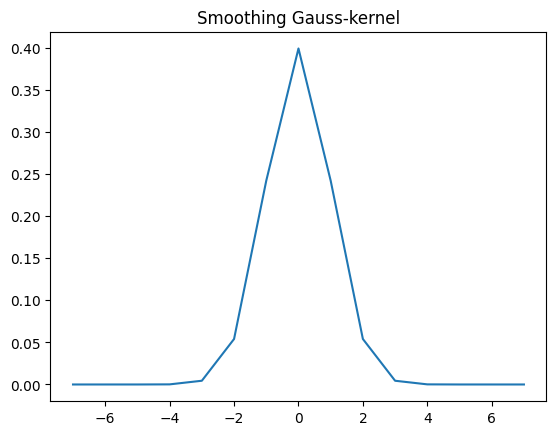

In [68]:
# 16 long gauss convolutional kernel
x = np.arange(-7,8,1)
sigma = 1
normal = 1 / (2.0 * np.pi * sigma**2)
gauss_kernel_beta =  np.exp(-((x**2) / (2.0*sigma**2))) * normal
gauss_kernel = gauss_kernel_beta / np.sum(gauss_kernel_beta)
plt.plot(x,gauss_kernel)
plt.title('Smoothing Gauss-kernel')

Text(0.5, 0.98, 'dF/F and smoothened dF/F signals of each neural compartment')

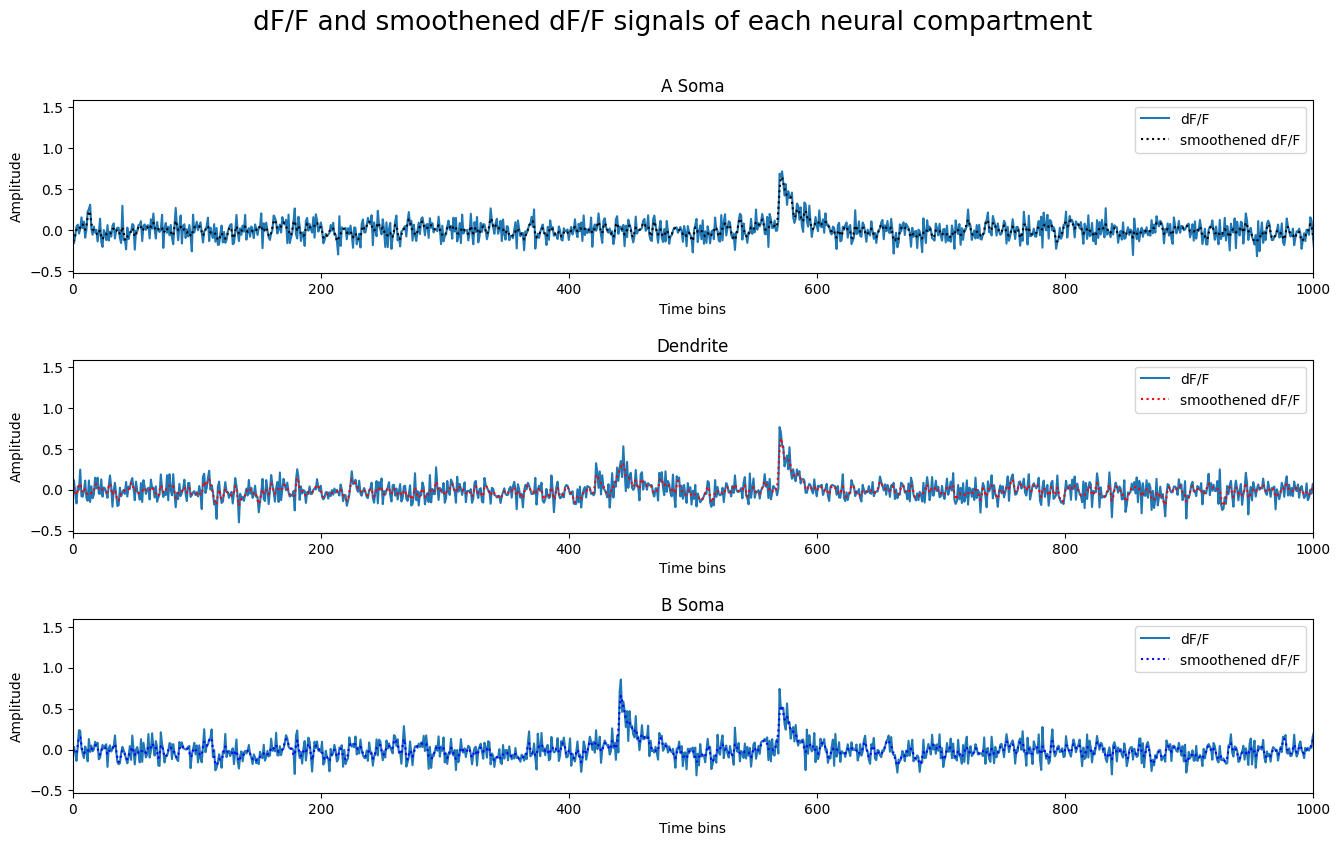

In [69]:
# plotting the gauss smoothed signals
a_events_smooth = np.convolve(signal1,gauss_kernel, mode='valid')
dendritic_events_smooth = np.convolve(signal2,gauss_kernel, mode='valid')
b_events_smooth = np.convolve(signal3,gauss_kernel, mode='valid')

fig, axs = plt.subplots(3, 1,figsize=(16,9), sharey=True)
plt.subplots_adjust(hspace=0.5)

axs[0].plot(sigs[0], label = 'dF/F')
axs[0].plot(a_events_smooth, ':k', label = 'smoothened dF/F')
axs[1].plot(sigs[1], label = 'dF/F')
axs[1].plot(dendritic_events_smooth, ':r', label = 'smoothened dF/F')
axs[2].plot(sigs[2], label = 'dF/F')
axs[2].plot(b_events_smooth, ':b', label = 'smoothened dF/F')
axs[0].title.set_text('A Soma')
axs[1].title.set_text('Dendrite')
axs[2].title.set_text('B Soma')
axs[0].set_xlabel('Time bins')
axs[1].set_xlabel('Time bins')
axs[2].set_xlabel('Time bins')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[2].set_ylabel('Amplitude')
axs[0].set_xlim(0,1000)
axs[1].set_xlim(0,1000)
axs[2].set_xlim(0,1000)
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.suptitle('dF/F and smoothened dF/F signals of each neural compartment', fontsize=19)

## Data analysis - event detection

Event detection function that detects the events above a specific threshold (theta_upper) and assign a decay period to it, which is remaining part of the signal array until it reaches a secondary threshold (theta_lower). Theta lower is set below the signal orginal signal detector. The function uses a simple way to detect specific events: When the signal reaches the threshold, the function observes whether the N-1th element is lower then the event threshold and the Nth element is higher, so it returns TRUE. If this is not the signal must not be detected so signal did not go above theta_upper, however it did not go above theta_lower, whihc means it is stll a decay period and rmust return FALSE.

In [71]:
def event_detector(signal, theta_upper = 1.65, theta_lower = 1.6): 
    
    N = len(signal)
    
    event = np.zeros(N)
    transient = np.zeros(N)
    start_end = []
    
    refr = 0
    start_end_i = np.zeros(2)
    
    for i in np.arange(1,N):
        if ((signal[i] > theta_upper) and (signal[i-1] < theta_upper) and (refr == 0)):
            event[i] = 1 
            refr = 1
            start_end_i[0] = i
        if ((signal[i]<theta_lower) and (signal[i-1] > theta_lower) and (refr == 1)):
            refr = 0
            start_end_i[1] = i
            start_end.append(start_end_i)
            start_end_i = np.zeros(2)
        if (refr == 1):
            transient[i] = 1
    if ((start_end_i[0] > 0) & (start_end_i[1] == 0)):
        start_end_i[1] = N
        start_end.append(start_end_i)
    
    return event

In [72]:
sig1_event = event_detector(a_events_smooth, .25, .1)
sig2_event = event_detector(dendritic_events_smooth, .25, .1)
sig3_event = event_detector(b_events_smooth, .25, .1)

Plot the smoothened signals, the detected events and the original spikes:

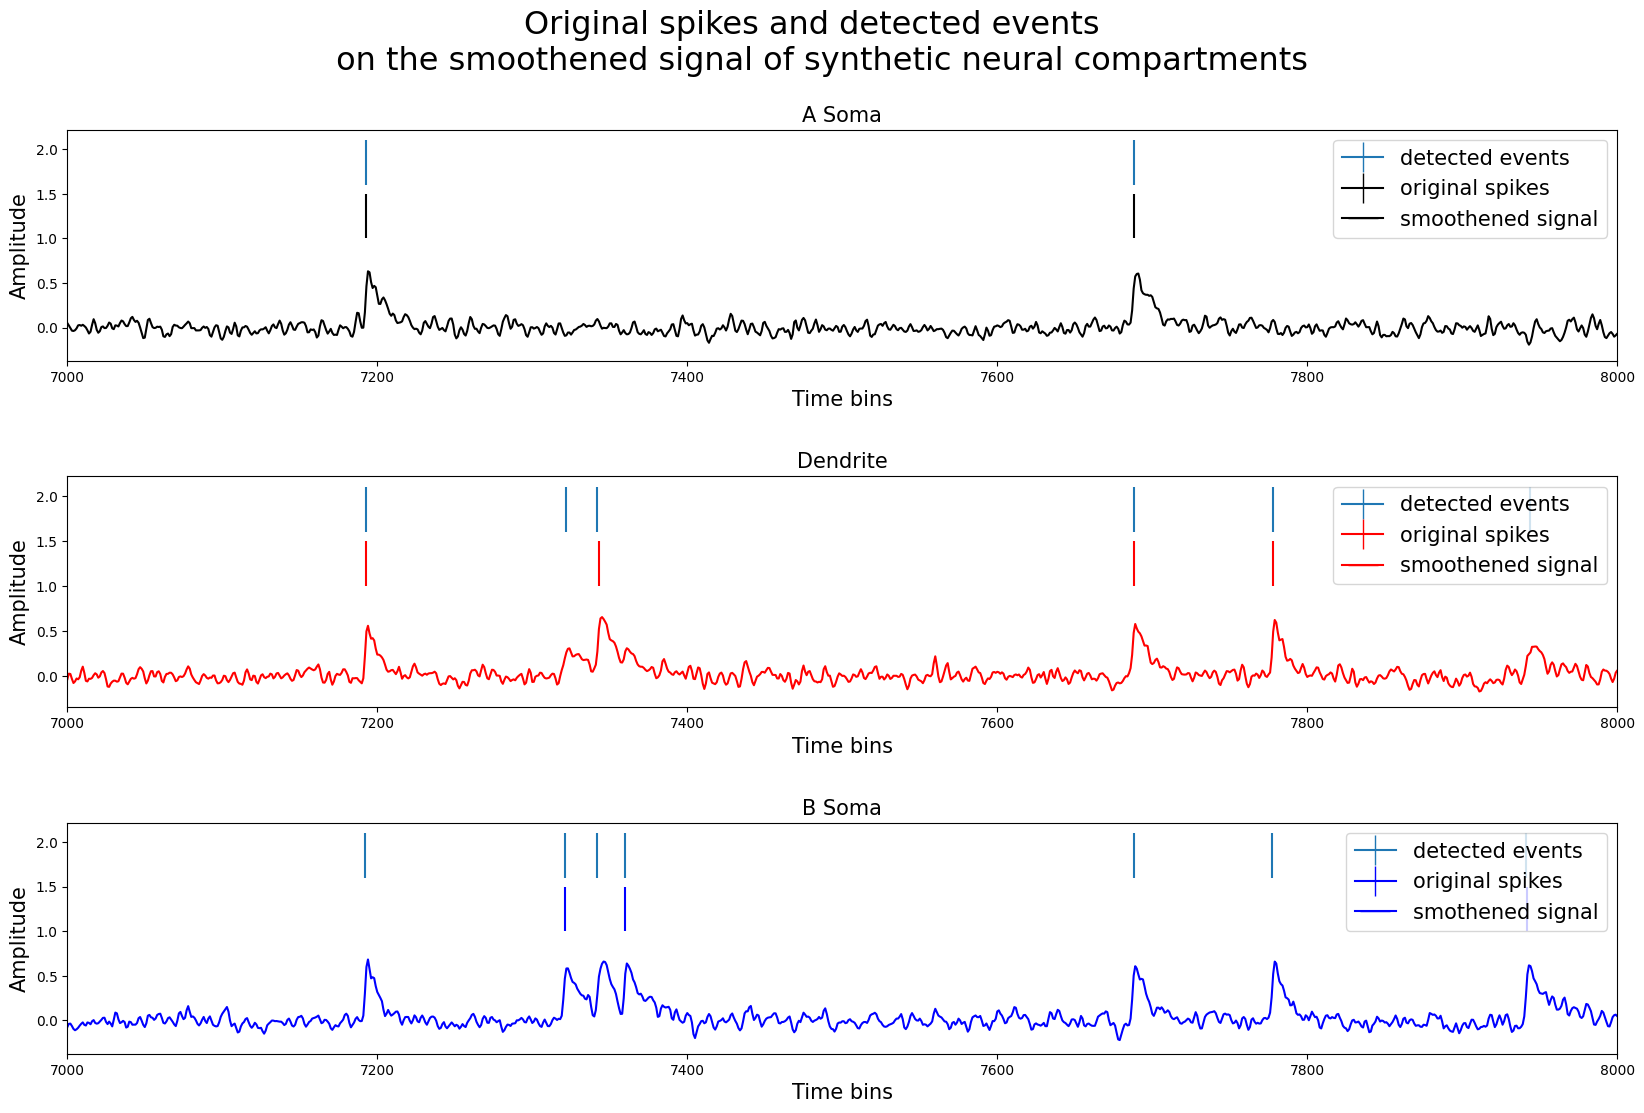

In [95]:
#%matplotlib
import matplotlib.lines as mlines

fig, axs = plt.subplots(3, 1,figsize = (20,12))
plt.subplots_adjust(hspace=0.5)

#plots

axs[0].vlines(np.flatnonzero(spikes_a), 1, 1.5, 'k',  label = 'Inline label')
axs[1].vlines(np.flatnonzero(spikes_a+spikes_a_dend), 1, 1.5, 'r')
axs[2].vlines(np.flatnonzero(spikes_b), 1, 1.5, 'b')

# # axs[0].plot(sigs[0])
axs[0].plot(a_events_smooth, color = 'k')
axs[0].vlines(np.flatnonzero(sig1_event), 1.6, 2.1)


# # axs[1].plot(sigs[1])
axs[1].plot(dendritic_events_smooth, color = 'r')
axs[1].vlines(np.flatnonzero(sig2_event), 1.6, 2.1)

# # axs[2].plot(sigs[2])
axs[2].plot(b_events_smooth, color = 'b')
axs[2].vlines(np.flatnonzero(sig3_event), 1.6, 2.1)

#basic line
basic_line = mlines.Line2D([], [], marker = '|',
                          markersize = 22, label = 'detected events')
# #vlines
black_line = mlines.Line2D([], [], color = 'k', marker ='|',
                          markersize = 22, label ='original spikes')

red_line = mlines.Line2D([], [], color = 'red', marker ='|',
                          markersize = 22, label ='original spikes')

blue_line = mlines.Line2D([], [], color = 'blue', marker ='|',
                          markersize = 22, label = 'original spikes')

# #hlines
Hblack_line = mlines.Line2D([], [], color = 'k', marker ='_',
                          markersize = 22, label ='smoothened signal')

Hred_line = mlines.Line2D([], [], color = 'red', marker = '_',
                          markersize = 22, label = 'smoothened signal')

Hblue_line = mlines.Line2D([], [], color = 'blue', marker ='_',
                          markersize = 22, label ='smothened signal')


axs[0].set_title('A Soma', fontsize = 15)
axs[1].set_title('Dendrite', fontsize = 15)
axs[2].set_title('B Soma', fontsize = 15)
axs[0].set_xlim(7000, 8000) #2150, 3150
axs[1].set_xlim(7000, 8000)
axs[2].set_xlim(7000, 8000)
axs[0].set_xlabel('Time bins', fontsize = 15)
axs[1].set_xlabel('Time bins', fontsize = 15)
axs[2].set_xlabel('Time bins', fontsize = 15)
axs[0].set_ylabel('Amplitude', fontsize = 15)
axs[1].set_ylabel('Amplitude', fontsize = 15)
axs[2].set_ylabel('Amplitude', fontsize = 15)
axs[0].legend(handles = [basic_line, black_line, Hblack_line], loc = 'upper right', prop = {'size': 15})
axs[1].legend(handles = [basic_line, red_line, Hred_line], loc = 'upper right', prop = {'size': 15})
axs[2].legend(handles = [basic_line, blue_line, Hblue_line], loc = 'upper right', prop = {'size': 15})

fig.suptitle('Original spikes and detected events \n on the smoothened signal of synthetic neural compartments', fontsize=23)
plt.savefig('events.png')

Save data of every phase of synthetic data generation:

In [44]:
synthetic_dF0 = np.save('synthetic_dF0', dF0)

synthetic_dF = np.save('synthetic_dF', dF)

synthetic_a_soma_signal_smooth = np.save('synthetic_a_soma_signal_smooth', a_events_smooth)
synthetic_a_dendrite_signal_smooth = np.save('synthetic_a_dendrite_signal_smooth', dendritic_events_smooth)
synthetic_b_soma_signal_smooth = np.save('synthetic_b_soma_signal_smooth', b_events_smooth)

synthetic_somatic_event1 = np.save('synthetic_somatic_event1', sig1_event)
synthetic_dendritic_event = np.save('synthetic_dendritic_event', sig2_event)
synthetic_somatic_event2 = np.save('synthetic_somatic_event2', sig3_event)

synthetic_spikes_a_dendrite  = spikes_a+spikes_a_dend
synthetic_spikes_a_soma = np.save('synthetic_spikes_a_soma', spikes_a)
synthetic_spikes_a_dendrite = np.save('synthetic_spikes_a_dendrite', synthetic_spikes_a_dendrite)
synthetic_spikes_b_soma = np.save('synthetic_spikes_b_soma', spikes_b)

synthetic_a_soma_roi = np.save('synthetic_a_soma_roi',a_soma)
synthetic_a_dendrite_roi = np.save('synthetic_a_dendrite_roi',dendrites)
synthetic_b_soma_roi = np.save('synthetic_b_soma_roi',b_soma)

synthetic_raw_signal_a_soma = np.save('synthetic_raw_signal_a_soma',sigs[0])
synthetic_raw_signal_a_dendrite = np.save('synthetic_raw_signal_a_dendrite',sigs[1])
synthetic_raw_signal_b_soma= np.save('synthetic_raw_signal_b_soma',sigs[2])